In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

from scipy import stats
from termcolor import colored
import urllib.parse
from sqlalchemy import create_engine
import pylab
from datetime import timedelta
import random
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers




In [2]:
df = pd.read_csv(r"C:\Users\shahi\Downloads\Medical_Inventory_Combined.csv", parse_dates=['Dateofbill'])
df.head()


,Typeofsales,Patient_ID,Specialisation,Dept,Dateofbill,Quantity,ReturnQuantity,Final_Cost,Final_Sales,RtnMRP,Formulation,DrugName,SubCat,SubCat1
0,Sale,12018098765,Specialisation6,Department1,2022-01-06,1,0,55.406,59.260,0.0,Form1,ZINC ACETATE 20MG/5ML SYP,SYRUP & SUSPENSION,VITAMINS & MINERALS
1,Sale,12018103897,Specialisation7,Department1,2022-07-23,1,0,768.638,950.800,0.0,Form1,CEFTAZIDIME 2GM+AVIBACTAM 500MG,INJECTIONS,ANTI-INFECTIVES
2,Sale,12018101123,Specialisation2,Department3,2022-06-23,1,0,774.266,4004.214,0.0,Form2,EPTIFIBATIDE 0.75MG/ML,INJECTIONS,CARDIOVASCULAR & HEMATOPOIETIC SYSTEM
3,Sale,12018079281,Specialisation40,Department1,2022-03-17,2,0,40.798,81.044,0.0,Form1,WATER FOR INJECTION 10ML SOLUTION,INJECTIONS,INTRAVENOUS & OTHER STERILE SOLUTIONS
4,Sale,12018117928,Specialisation5,Department1,2022-12-21,1,0,40.434,40.504,0.0,Form1,LORAZEPAM 1MG,TABLETS & CAPSULES,CENTRAL NERVOUS SYSTEM


## 🧼 **2. DATA PREPROCESSING**

In [27]:
df.shape

(28436, 14)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28384 entries, 0 to 28435
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Typeofsales     28384 non-null  object 
 1   Patient_ID      28384 non-null  int64  
 2   Specialisation  28384 non-null  object 
 3   Dept            28384 non-null  object 
 4   Dateofbill      28384 non-null  object 
 5   Quantity        28384 non-null  int64  
 6   ReturnQuantity  28384 non-null  int64  
 7   Final_Cost      28384 non-null  float64
 8   Final_Sales     28384 non-null  float64
 9   RtnMRP          28384 non-null  float64
 10  Formulation     27084 non-null  object 
 11  DrugName        25066 non-null  object 
 12  SubCat          25066 non-null  object 
 13  SubCat1         25020 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 3.2+ MB


**Descriptive Statistics of Numerical Columns :**

In [29]:
print(colored("Descriptive Statistics of Numerical Columns :\n\n",'blue',attrs=['bold']))
df.describe()


Descriptive Statistics of Numerical Columns :




,Patient_ID,Quantity,ReturnQuantity,Final_Cost,Final_Sales,RtnMRP
count,2.843600e+04,28436.000000,28436.000000,28436.000000,28436.000000,28436.000000
mean,1.201809e+10,2.231748,0.291954,124.823957,234.038300,29.126755
std,2.810180e+04,5.131952,1.643293,464.774621,671.249768,182.259131
min,1.201800e+10,0.000000,0.000000,40.000000,0.000000,0.000000
25%,1.201808e+10,1.000000,0.000000,44.928000,47.800000,0.000000
50%,1.201809e+10,1.000000,0.000000,53.650000,86.424000,0.000000
75%,1.201811e+10,2.000000,0.000000,77.800000,181.000000,0.000000
max,1.201813e+10,150.000000,50.000000,33178.000000,39490.000000,8014.000000


In [30]:
print(colored("Descriptive Statistics of Categorical Columns :\n\n",'blue',attrs=['bold']),df.describe(include=object).T)


Descriptive Statistics of Categorical Columns :

                 count unique                                    top   freq
Typeofsales     28436      2                                   Sale  25074
Specialisation  28436     58                        Specialisation4   7998
Dept            28436      3                            Department1  24880
Dateofbill      28436    730                    2022-07-07 00:00:00     70
Formulation     27130      4                                  Form1  23244
DrugName        25100    751              SODIUM CHLORIDE IVF 100ML   1208
SubCat          25100     17                             INJECTIONS  13000
SubCat1         25052     21  INTRAVENOUS & OTHER STERILE SOLUTIONS   6384


**Checking the Number of Duplicates in the Dataset**


In [31]:

duplicate_values=df.duplicated(subset=None,keep='first').sum()
print(' Number of Duplicate values: ',duplicate_values)


 Number of Duplicate values:  52


In [32]:

df.drop_duplicates(keep='first',inplace=True)
duplicate_values=df.duplicated(subset=None,keep='first').sum()
print(colored(' Again checking the number of duplictate values: ','blue',attrs=['bold']),duplicate_values)

 Again checking the number of duplictate values:  0


In [5]:
# Handle missing + categorical safely
for col in ['Typeofsales', 'DrugName']:
    if df[col].dtype.name != 'category':
        df[col] = df[col].astype('category')
    if 'Unknown' not in df[col].cat.categories:
        df[col] = df[col].cat.add_categories(['Unknown'])
    df[col].fillna('Unknown', inplace=True)

# Create time-based features
df['year'] = df['Dateofbill'].dt.year
df['month'] = df['Dateofbill'].dt.month
df['day'] = df['Dateofbill'].dt.day
df['dayofweek'] = df['Dateofbill'].dt.dayofweek

# Sort and fill other missing values
df.sort_values(['DrugName', 'Dateofbill'], inplace=True)
df.fillna(0, inplace=True)


## **EDA**

In [34]:
# Unique values in important columns
print("Number of unique drugs:", df['DrugName'].nunique())
print("\nTop 10 Drugs:\n", df['DrugName'].value_counts().head(10))



Number of unique drugs: 751

Top 10 Drugs:
 SODIUM CHLORIDE IVF 100ML             1208
SODIUM CHLORIDE 0.9%                  1050
MULTIPLE ELECTROLYTES 500ML IVF        934
ONDANSETRON 2MG/ML                     886
PANTOPRAZOLE 40MG INJ                  882
PARACETAMOL 1GM IV INJ                 792
LIGNOCAINE HYDROCHLORIDE 2% INJ        520
PIPERACILLIN 4GM+ TAZOBACTAM 500MG     510
WATER FOR INJECTION 10ML SOLUTION      510
HUMAN ALBUMIN 25% INJ                  356
Name: DrugName, dtype: int64


In [35]:
print(df['Typeofsales'].value_counts())

Sale      25032
Return     3352
Name: Typeofsales, dtype: int64


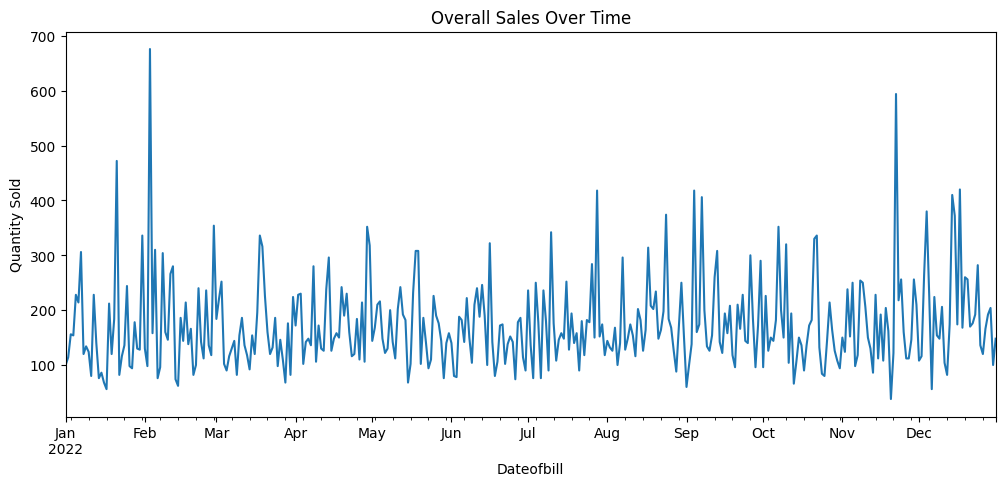

In [3]:
# Sales trend
plt.figure(figsize=(12, 5))
df.groupby('Dateofbill')['Quantity'].sum().plot()
plt.title("Overall Sales Over Time")
plt.ylabel("Quantity Sold")
plt.show()



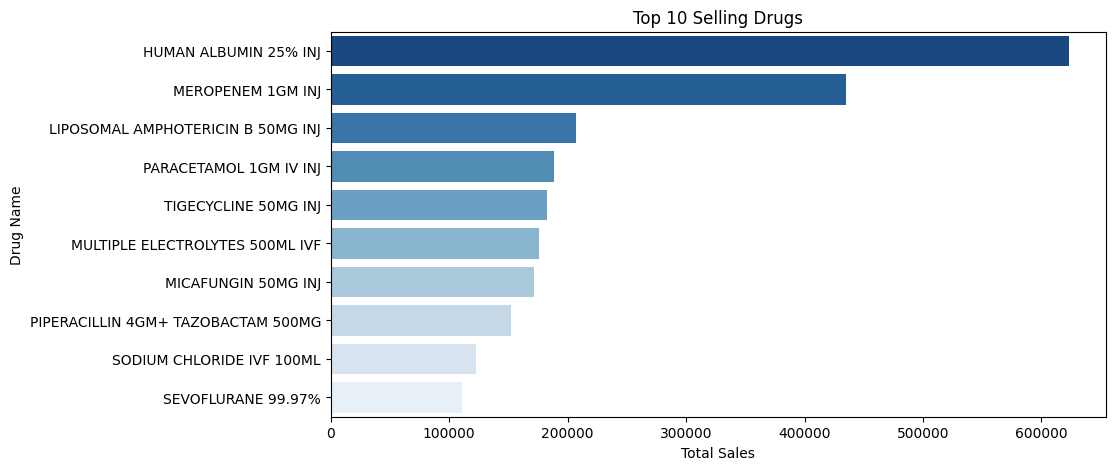

In [36]:
#Top Selling Drugs
top_drugs = df.groupby('DrugName')['Final_Sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='Blues_r')
plt.title('Top 10 Selling Drugs')
plt.xlabel('Total Sales')
plt.ylabel('Drug Name')
plt.show()

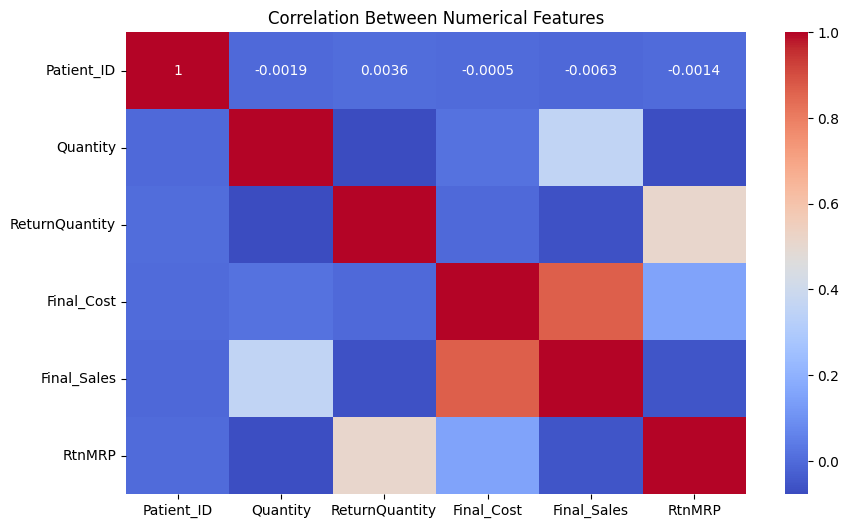

In [37]:
#Correlation heatmap (numerical features only)
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numerical Features")
plt.show()

## **RANDOM FOREST REGRESSOR**

R² Score: 0.8735
RMSE: 1.1071


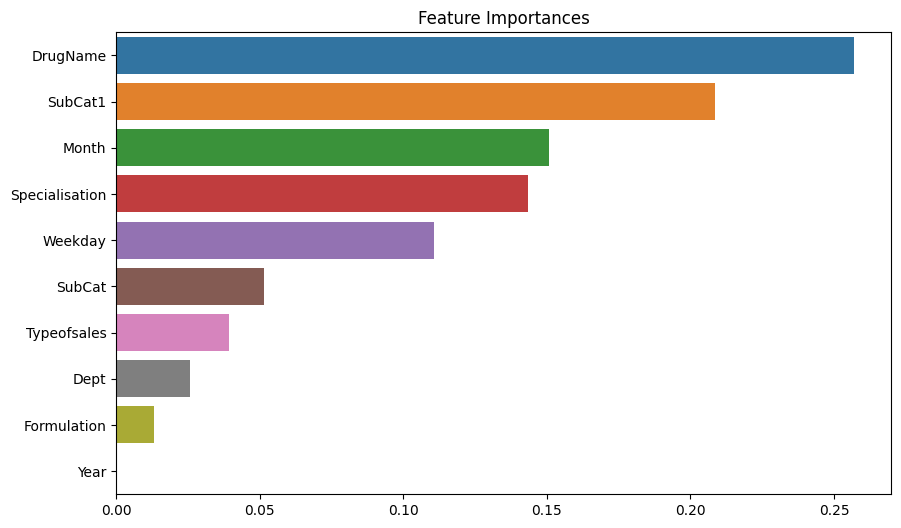

In [6]:
## Preprocessing
df['Dateofbill'] = pd.to_datetime(df['Dateofbill'], errors='coerce')
df = df.dropna(subset=['Dateofbill', 'DrugName', 'SubCat', 'SubCat1'])

df['Month'] = df['Dateofbill'].dt.month
df['Weekday'] = df['Dateofbill'].dt.weekday
df['Year'] = df['Dateofbill'].dt.year

categorical_cols = ['Typeofsales', 'Specialisation', 'Dept', 'Formulation', 'DrugName', 'SubCat', 'SubCat1']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

## Feature Selection
features = ['Typeofsales', 'Specialisation', 'Dept', 'Formulation', 'DrugName',
            'SubCat', 'SubCat1', 'Month', 'Weekday', 'Year']
target = 'Quantity'

X = df[features]
y = df[target]

## Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

##  Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

## Evaluation
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

## Feature Importance (Optional)
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importances")
plt.show()


In [8]:
y_pred = model.predict(X)

In [9]:
df_predictions = pd.DataFrame({
    'Actual': y,
    'Predicted': y_pred
})

print(df_predictions.head(10))  # Show first 10 predictions


   Actual  Predicted
0       1     1.1400
1       1     1.0800
2       1     1.0300
3       2     2.0800
4       1     1.1700
5       0     0.0000
6       1     1.3300
7       3     3.1605
8       2     2.0100
9       1     1.0000


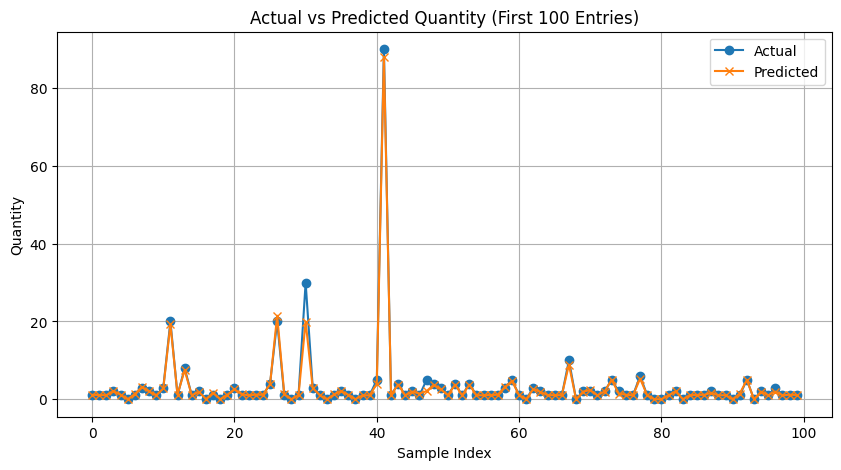

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(df_predictions['Actual'].values[:100], label='Actual', marker='o')
plt.plot(df_predictions['Predicted'].values[:100], label='Predicted', marker='x')
plt.title('Actual vs Predicted Quantity (First 100 Entries)')
plt.xlabel('Sample Index')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

## **Q-learning Model**

Using top-selling product: SODIUM CHLORIDE IVF 100ML
✅ Q-learning training completed.


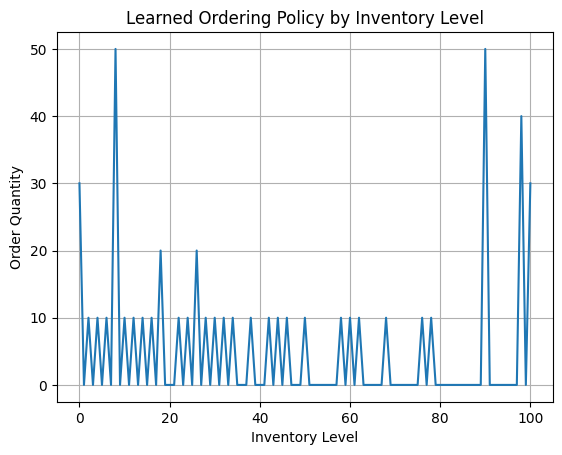

In [25]:
# Use top-selling product
top_product = df[df['Typeofsales'] == 'Sale'].groupby('DrugName').size().idxmax()
print("Using top-selling product:", top_product)

# Filter the product and process demand
filtered_df = df[(df['DrugName'] == top_product) & (df['Typeofsales'] == 'Sale')].copy()
filtered_df['Dateofbill'] = pd.to_datetime(filtered_df['Dateofbill'])
daily_demand = filtered_df.groupby('Dateofbill')['Quantity'].sum().sort_index()

# Fill missing dates
full_range = pd.date_range(start=daily_demand.index.min(), end=daily_demand.index.max())
daily_demand = daily_demand.reindex(full_range, fill_value=0)

# Q-learning environment setup
class InventoryEnv:
    def __init__(self, demand_series, max_inventory=100):
        self.demand = demand_series.values
        self.max_inventory = max_inventory
        self.reset()

    def reset(self):
        self.day = 0
        self.inventory = 50
        return self.inventory

    def step(self, action):
        order_qty = action
        self.inventory = min(self.max_inventory, self.inventory + order_qty)
        demand = self.demand[self.day]
        sales = min(self.inventory, demand)
        self.inventory -= sales
        reward = sales * 10 - (self.inventory * 0.5) - ((demand - sales) * 20)
        self.day += 1
        done = self.day >= len(self.demand)
        return self.inventory, reward, done

# Q-learning agent
env = InventoryEnv(daily_demand)
actions = [0, 10, 20, 30, 40, 50]
q_table = np.zeros((env.max_inventory + 1, len(actions)))

# Training parameters
alpha = 0.1
gamma = 0.95
epsilon = 0.1
episodes = 500

for ep in range(episodes):
    state = env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) < epsilon:
            action_idx = random.randint(0, len(actions) - 1)
        else:
            action_idx = np.argmax(q_table[state])

        next_state, reward, done = env.step(actions[action_idx])
        q_table[state, action_idx] += alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action_idx])
        state = next_state

print("✅ Q-learning training completed.")

# Plot learned policy
best_actions = [actions[np.argmax(q_table[i])] for i in range(env.max_inventory + 1)]
plt.plot(best_actions)
plt.title("Learned Ordering Policy by Inventory Level")
plt.xlabel("Inventory Level")
plt.ylabel("Order Quantity")
plt.grid()
plt.show()


In [26]:
def evaluate_policy(env, q_table, episodes=10):
    total_rewards = []
    for _ in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action_idx = np.argmax(q_table[state])
            state, reward, done = env.step(actions[action_idx])
            episode_reward += reward
        total_rewards.append(episode_reward)
    return np.mean(total_rewards), np.std(total_rewards)

def baseline_policy(env, order_qty, episodes=10):
    total_rewards = []
    for _ in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            state, reward, done = env.step(order_qty)
            episode_reward += reward
        total_rewards.append(episode_reward)
    return np.mean(total_rewards), np.std(total_rewards)

# Evaluate Q-learning agent
mean_reward, std_reward = evaluate_policy(env, q_table)
print(f"Q-learning policy average reward: {mean_reward:.2f} ± {std_reward:.2f}")

# Evaluate baseline fixed order (e.g., always order 20 units)
mean_fixed, std_fixed = baseline_policy(env, order_qty=20)
print(f"Fixed order (20 units) policy average reward: {mean_fixed:.2f} ± {std_fixed:.2f}")


Q-learning policy average reward: 16049.00 ± 0.00
Fixed order (20 units) policy average reward: 8871.00 ± 0.00


## **Deep Q-learning Model**

Episode 1: Total Reward = 11585.50
Episode 2: Total Reward = 13688.00
Episode 3: Total Reward = 12155.50
Episode 4: Total Reward = 15604.50
Episode 5: Total Reward = 14995.50
Episode 6: Total Reward = 16257.00
Episode 7: Total Reward = 15213.00
Episode 8: Total Reward = 14441.50
Episode 9: Total Reward = 17463.50
Episode 10: Total Reward = 13004.50
Deep Q-learning training complete.


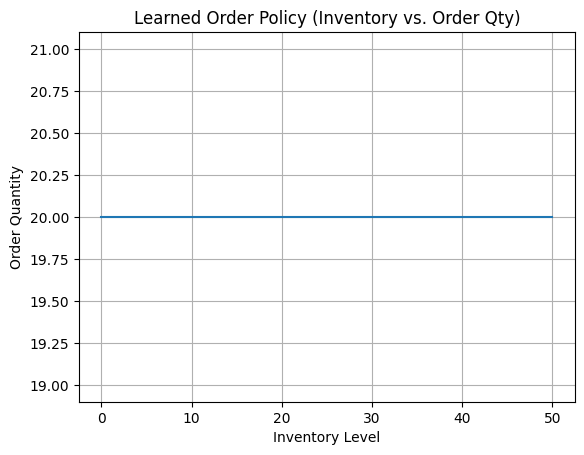

In [20]:
product_name = df[df['Typeofsales'] == 'Sale'].groupby('DrugName').size().idxmax()
filtered_df = df[(df['DrugName'] == product_name) & (df['Typeofsales'] == 'Sale')].copy()
filtered_df['Dateofbill'] = pd.to_datetime(filtered_df['Dateofbill'])
daily_demand = filtered_df.groupby('Dateofbill')['Quantity'].sum().sort_index()
full_range = pd.date_range(start=daily_demand.index.min(), end=daily_demand.index.max())
daily_demand = daily_demand.reindex(full_range, fill_value=0)

# Simple Inventory Environment
class InventoryEnv:
    def __init__(self, demand, max_inventory=50):
        self.demand = demand
        self.max_inventory = max_inventory
        self.reset()

    def reset(self):
        self.day = 0
        self.inventory = 25
        return np.array([self.inventory])

    def step(self, action):
        self.inventory = min(self.max_inventory, self.inventory + action)
        demand_today = self.demand[self.day]
        sales = min(self.inventory, demand_today)
        self.inventory -= sales
        reward = sales * 10 - self.inventory * 0.5 - (demand_today - sales) * 20
        self.day += 1
        done = self.day >= len(self.demand)
        return np.array([self.inventory]), reward, done

# Define the tiny Q-network (reduced layers)
def build_model(input_size, output_size):
    model = models.Sequential()
    model.add(layers.Dense(4, input_dim=input_size, activation='relu'))  # Smaller layer
    model.add(layers.Dense(output_size, activation='linear'))  # Output layer
    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.01))
    return model

# Actions: Reduced action space for faster computation
actions = [0, 10, 20]  
state_size = 1
action_size = len(actions)
model = build_model(state_size, action_size)

# Parameters for training (reduced episodes for faster results)
episodes = 10
gamma = 0.9
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.95

env = InventoryEnv(daily_demand)

# Training loop with faster execution
for e in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        if np.random.rand() <= epsilon:
            action_idx = random.randint(0, action_size - 1)  # Explore random action
        else:
            q_values = model.predict(state.reshape(1, -1), verbose=0)
            action_idx = np.argmax(q_values[0])  # Exploit best action
        action = actions[action_idx]
        next_state, reward, done = env.step(action)
        target = reward
        if not done:
            target += gamma * np.amax(model.predict(next_state.reshape(1, -1), verbose=0)[0])  # Q-update
        target_vec = model.predict(state.reshape(1, -1), verbose=0)[0]
        target_vec[action_idx] = target
        model.fit(state.reshape(1, -1), target_vec.reshape(1, -1), epochs=1, verbose=0)
        state = next_state
        total_reward += reward
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {e+1}: Total Reward = {total_reward:.2f}")

print("Deep Q-learning training complete.")

# Plot learned policy
states = np.arange(0, env.max_inventory + 1)
actions_learned = []

for s in states:
    q_values = model.predict(np.array([[s]]), verbose=0)
    best_action = actions[np.argmax(q_values[0])]
    actions_learned.append(best_action)

plt.plot(states, actions_learned)
plt.title("Learned Order Policy (Inventory vs. Order Qty)")
plt.xlabel("Inventory Level")
plt.ylabel("Order Quantity")
plt.grid()
plt.show()


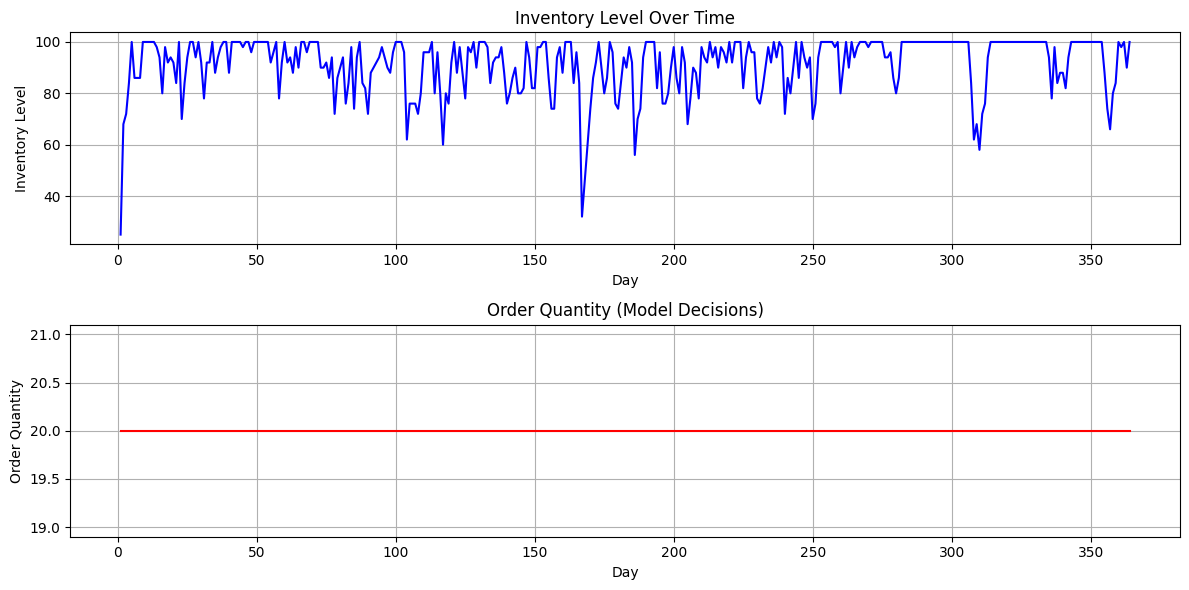

✅ Total Reward over 364 days: 8871.00


In [22]:
class InventoryEnv:
    def __init__(self, demand_series, max_inventory=100):
        self.demand = demand_series.values
        self.max_inventory = max_inventory
        self.reset()

    def reset(self):
        self.day = 0
        self.inventory = 50  # starting inventory
        return np.array([self.inventory])

    def step(self, action):
        if self.day >= len(self.demand):  # safeguard
            return np.array([self.inventory]), 0, True

        self.inventory = min(self.max_inventory, self.inventory + action)
        demand_today = self.demand[self.day]
        sales = min(self.inventory, demand_today)
        self.inventory -= sales

        reward = (sales * 10) - (self.inventory * 0.5) - ((demand_today - sales) * 20)

        self.day += 1
        done = self.day >= len(self.demand)

        return np.array([self.inventory]), reward, done

# Simulate learned policy
initial_inventory = 25
env = InventoryEnv(daily_demand, max_inventory=100)

state = np.array([initial_inventory])
total_reward = 0
history = []

while True:
    # Choose best action from model
    q_values = model.predict(state.reshape(1, -1), verbose=0)
    best_action_idx = np.argmax(q_values[0])
    action = actions[best_action_idx]

    # Apply action
    next_state, reward, done = env.step(action)

    # Record result
    history.append({
        'day': len(history) + 1,
        'inventory_level': state[0],
        'action': action,
        'reward': reward
    })

    total_reward += reward
    state = next_state

    if done:
        break

# Convert to DataFrame
history_df = pd.DataFrame(history)

# Plot Inventory and Action over Time
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(history_df['day'], history_df['inventory_level'], label="Inventory Level", color="blue")
plt.title("Inventory Level Over Time")
plt.xlabel("Day")
plt.ylabel("Inventory Level")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history_df['day'], history_df['action'], label="Order Quantity", color="red")
plt.title("Order Quantity (Model Decisions)")
plt.xlabel("Day")
plt.ylabel("Order Quantity")
plt.grid(True)

plt.tight_layout()
plt.show()

# Print total reward
print(f"✅ Total Reward over {len(history)} days: {total_reward:.2f}")


In [23]:
def evaluate_dqn_policy(env, model, actions):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        q_values = model.predict(state.reshape(1, -1), verbose=0)
        action = actions[np.argmax(q_values[0])]
        state, reward, done = env.step(action)
        total_reward += reward
    return total_reward

eval_reward = evaluate_dqn_policy(env, model, actions)
print(f"✅ DQN policy evaluation total reward: {eval_reward:.2f}")


✅ DQN policy evaluation total reward: 8871.00


In [24]:
def evaluate_fixed_policy(env, fixed_order_qty):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        state, reward, done = env.step(fixed_order_qty)
        total_reward += reward
    return total_reward

baseline_reward = evaluate_fixed_policy(env, fixed_order_qty=20)
print(f"📊 Fixed policy reward (20 units): {baseline_reward:.2f}")


📊 Fixed policy reward (20 units): 8871.00


In [39]:
 #Actions and Q-table initialization
actions = [0, 10, 20, 30, 40, 50]
q_table = np.zeros((env.max_inventory + 1, len(actions)))

# Training loop
alpha = 0.1
gamma = 0.95
epsilon = 0.1
episodes = 500

for ep in range(episodes):
    state = env.reset()
    done = False
    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action_idx = np.random.randint(len(actions))
        else:
            action_idx = np.argmax(q_table[state])

        next_state, reward, done = env.step(actions[action_idx])
        q_table[state, action_idx] += alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action_idx])
        state = next_state


In [40]:
# Generating policy table
policy_table = []

for inventory_level in range(env.max_inventory + 1):
    best_action_idx = np.argmax(q_table[inventory_level])
    recommended_order = actions[best_action_idx]
    policy_table.append((inventory_level, recommended_order))

# Convert to DataFrame for better display
import pandas as pd
policy_df = pd.DataFrame(policy_table, columns=['Inventory Level', 'Recommended Order'])
display(policy_df.head(20))

,Inventory Level,Recommended Order
0,0,20
1,1,0
2,2,20
3,3,0
4,4,10
5,5,0
6,6,50
7,7,0
8,8,20
9,9,0


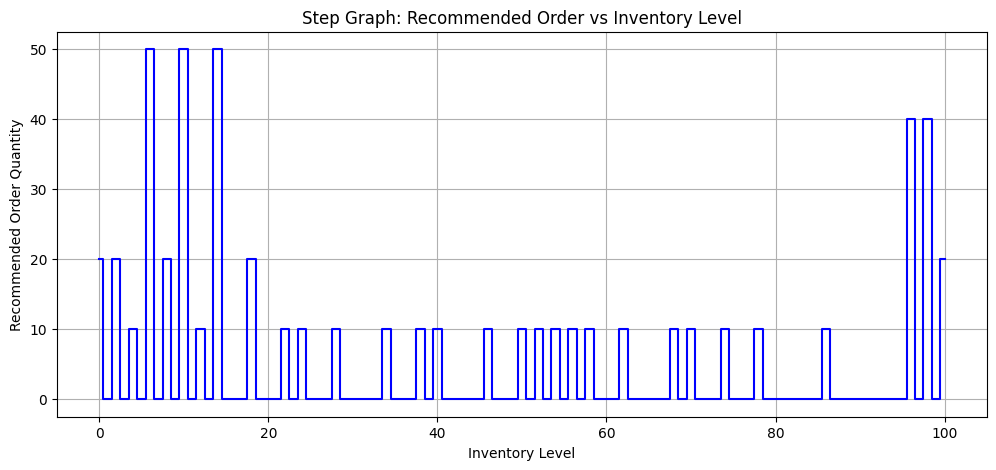

In [41]:
plt.figure(figsize=(12, 5))
plt.step(policy_df["Inventory Level"], policy_df["Recommended Order"], where='mid', color='blue')
plt.title("Step Graph: Recommended Order vs Inventory Level")
plt.xlabel("Inventory Level")
plt.ylabel("Recommended Order Quantity")
plt.grid(True)
plt.show()

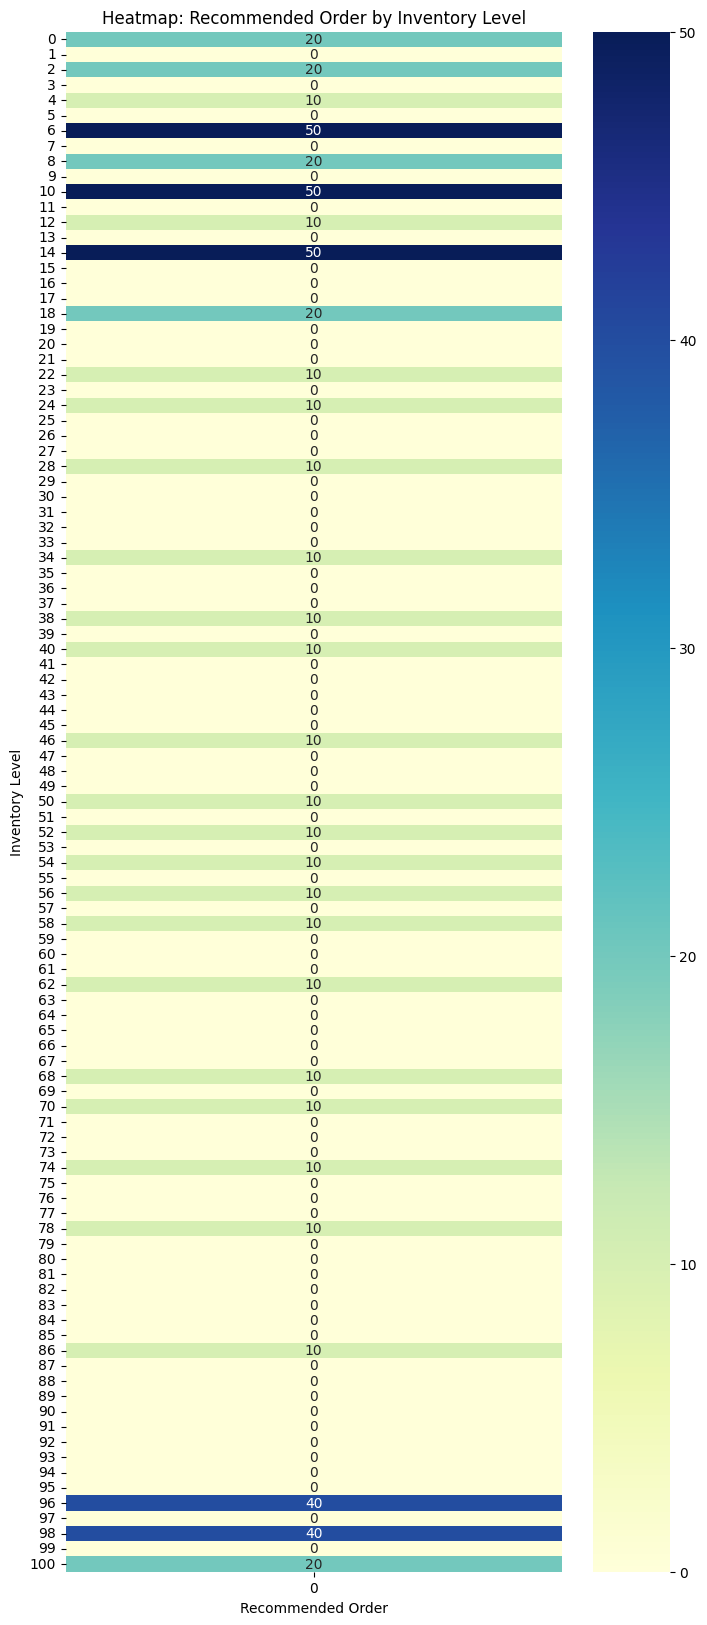

In [42]:
# Prepare data for heatmap (reshaped to fit heatmap format)
#using a simple 2D format: rows = Inventory Levels
heat_data = policy_df.set_index("Inventory Level")["Recommended Order"].values.reshape(-1, 1)

plt.figure(figsize=(8, 20))
sns.heatmap(heat_data, annot=True, fmt="d", cmap="YlGnBu", cbar=True,
            yticklabels=policy_df["Inventory Level"])
plt.title("Heatmap: Recommended Order by Inventory Level")
plt.xlabel("Recommended Order")
plt.ylabel("Inventory Level")
plt.show()